# GMDL HW2 - PCA and Autoencoders
In this assignment you will implement two dimensionality reduction schemes
we saw in class:
1. Principal Component Analysis (PCA)
2. Autoencoder

You will also implement an image denoising model to enhance the performance of a simple MLP classifier.

The data used in the following exercises is a subset of the MNIST dataset.
Randomly sample 10,000 images from MNIST train set (you may set a random.seed).



**Submitting**




*   Gal Meirom - 209089531
*   Tzlil Ben Naeh - 318835550



In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# EX1. PCA dimensionality reduction (20pts)

1. Implement the PCA procedure in the function ```perform_PCA()```.

Useful functions:
```
sklearn.preprocessing.StandardScaler
scipy.linalg.eigh
numpy.matmul
```
The input should be in vector form (i.e., flatten the input images beforehand).

2. Project the data to 2D, i.e, $\mathbb{R}^{784}↦ \mathbb{R}^2$.
3. Scatter plot the data using the 2D projection and class labels. You'll need to implement ```plot_projected_data()```


In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.colors as mcolors
def perform_PCA(X, n_components):
  """
  Implement the PCA algorithm.
  Input: X [numpy array] - shape: (N,784)
  Output: Projected data using n_components
  """
  x = StandardScaler().fit_transform(X)
  cov_mat = np.cov(x.T)
  eigenvalues, eigenvectors = np.linalg.eig(cov_mat)
  sorted = np.argsort(eigenvalues)[::-1]
  sorted_eigenvalues = eigenvalues[sorted]
  sorted_eigenvectors = eigenvectors[:, sorted]
  mat = sorted_eigenvectors[:, 0:n_components]
  red_x = np.matmul(x, mat)
  return red_x

def plot_projected_data(X, y,s):
    colors = list(mcolors.TABLEAU_COLORS.values())
    plt.figure(figsize=(10, 8))
    for label in np.unique(y):
        indices = y == label
        plt.scatter(X[indices, 0], X[indices, 1],
                    color=colors[label % len(colors)], label=str(label), alpha=0.7)
    # plt.colorbar(scatter)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title(s)
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    target_names = list(range(10))
    for color, i, target_name in zip(colors, target_names, target_names):
      plt.scatter(X[y == i, 0], X[y == i, 1], alpha=0.5, color=color, label=target_name)
    plt.show()

In [3]:
# Please use the (0.5, 0.5) normalization value, as
# they were used for training the MLP in EX5
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


# Sample 10K images
train_indices = np.random.choice(len(trainset), 10000, replace=False)
train_subset = Subset(trainset, train_indices)

trainloader = DataLoader(train_subset , batch_size=256, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=256, shuffle=False, num_workers=4)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4586425.28it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134711.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 239131.80it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5157154.51it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw




/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


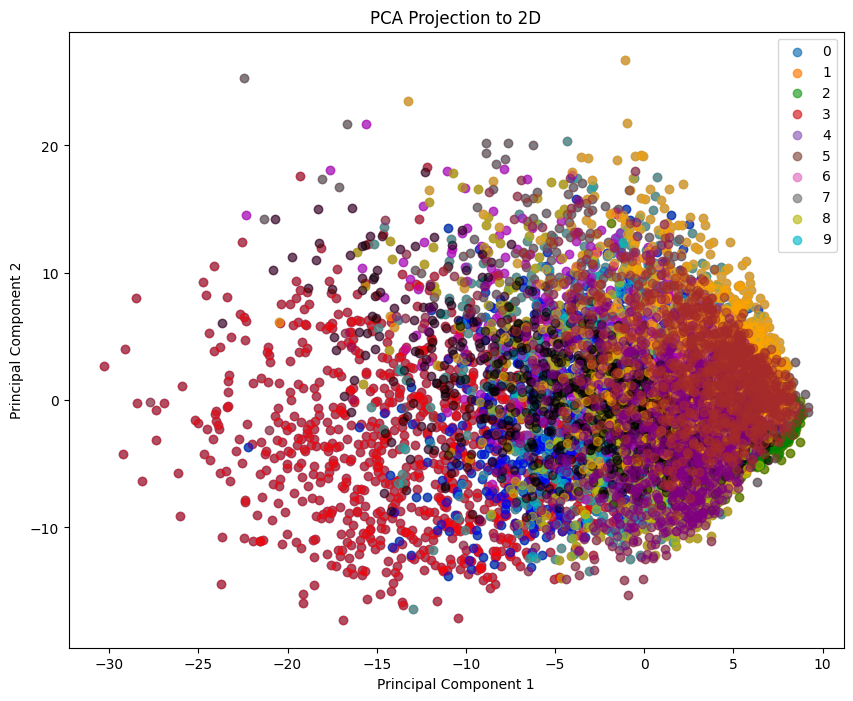

In [ ]:
### Your code goes here ###
all_data = []
all_labels = []

for data, labels in trainloader:
    data = data.view(data.size(0), -1)
    all_data.append(data)
    all_labels.append(labels)

# Concatenate the lists into tensors
all_data = torch.cat(all_data).numpy()
all_labels = torch.cat(all_labels).numpy()
x = perform_PCA(all_data, 2)
plot_projected_data(x, all_labels, "PCA Projection to 2D")

# EX2 Autoencoder (AE) (20pts)
1. Implement a fully-connected Autoencoder. The encoder and decoder should have 2 layers each. Use ReLU activation function.
2. The so-called 'code' should be two-dimensional. In other words, the output of the encoder should be 2.
3. Plot the training loss.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [4]:
!pip install optuna
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.8 MB/s eta 0:00:00


In [ ]:
class MLP_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, ess):
      super(MLP_AE, self).__init__()
      self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, ess),
            # nn.ReLU(),
            )
      self.decoder = nn.Sequential(
            nn.Linear(ess, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, input_dim),
            )

    def essence(self,x):
        return self.encoder(x)

    # def decoder(self, x):
    #   return self.decoder(x)

    def forward(self,x):
      x = x.view(-1, 784)
      x = self.encoder(x)
      x = self.decoder(x)
      x = x.view(-1,1,28,28)
      return x

In [ ]:
### Your code goes here ###

In [ ]:
def train(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    los = []
    with tqdm(total=epochs, unit="epoch", position=0, leave=True) as pbar:
      for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            # noisy_images = add_gaussian_noise(images)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        los.append(loss.item())
        pbar.set_postfix(loss=running_loss/len(train_loader))
        pbar.update(1)
        if epoch % 5 == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return los

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    input_dim = 28 * 28
    hidden_dim1 = trial.suggest_int('hidden_dim1', 64, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    model = MLP_AE(input_dim, hidden_dim1, hidden_dim2, 2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, _ in trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        train_loss /= len(trainloader.dataset)

    return train_loss

    # Create a study and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objective, n_trials=10)

    # Print the best trial
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-10 08:02:28,763] A new study created in memory with name: no-name-2a23cf6a-6951-41cc-ac95-c92181e9dacd
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-07-10 08:03:55,265] Trial 0 finished with value: 0.23846752181053163 and parameters: {'hidden_dim1': 317, 'hidden_dim2': 235, 'learning_rate': 4.749798811688311e-05}. Best is trial 0 with value: 0.23846752181053163.
[I 2024-07-10 08:05:00,464] Trial 1 finished with value: 0.260325576877594 and parameters: {'hidden_dim1': 505, 'hidden_dim2': 170, 'learning_rate': 0.04673107268530284}. Best is trial 0 

Best trial:
  Value: 0.19154849197864532
  Params: 
    hidden_dim1: 216
    hidden_dim2: 215
    learning_rate: 0.0005016725040710845


In [ ]:
# Initialize the model, loss function, and optimizer
# ae = MLP_AE(28*28, 216, 215, 2)
ae = MLP_AE(28*28, 216, 215, 2)
ae = ae.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ae.parameters(), lr=0.0005016725040710845)
print(ae)

MLP_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=216, bias=True)
    (1): ReLU()
    (2): Linear(in_features=216, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=215, bias=True)
    (1): ReLU()
    (2): Linear(in_features=215, out_features=784, bias=True)
  )
)


In [ ]:
loss = train(ae, trainloader, criterion, optimizer,  epochs=100)

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch [1/100], Loss: 0.4725
Epoch [6/100], Loss: 0.2281
Epoch [11/100], Loss: 0.2112
Epoch [16/100], Loss: 0.2013
Epoch [21/100], Loss: 0.1969
Epoch [26/100], Loss: 0.1934
Epoch [31/100], Loss: 0.1910
Epoch [36/100], Loss: 0.1889
Epoch [41/100], Loss: 0.1859
Epoch [46/100], Loss: 0.1846
Epoch [51/100], Loss: 0.1834
Epoch [56/100], Loss: 0.1821
Epoch [61/100], Loss: 0.1803
Epoch [66/100], Loss: 0.1801
Epoch [71/100], Loss: 0.1807
Epoch [76/100], Loss: 0.1790
Epoch [81/100], Loss: 0.1776
Epoch [86/100], Loss: 0.1763
Epoch [91/100], Loss: 0.1768
Epoch [96/100], Loss: 0.1756


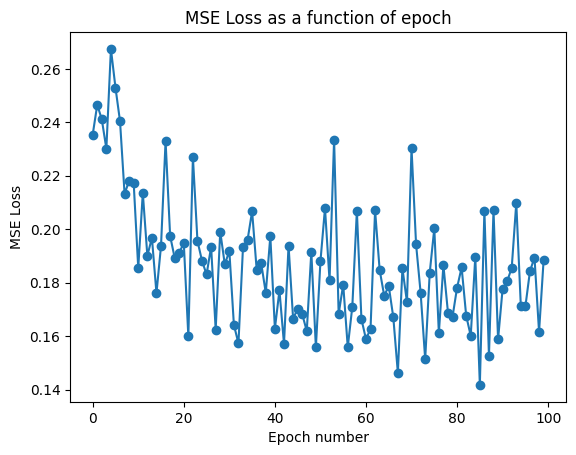

In [ ]:
plt.plot(loss, marker='o')
plt.title('MSE Loss as a function of epoch')
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.show()

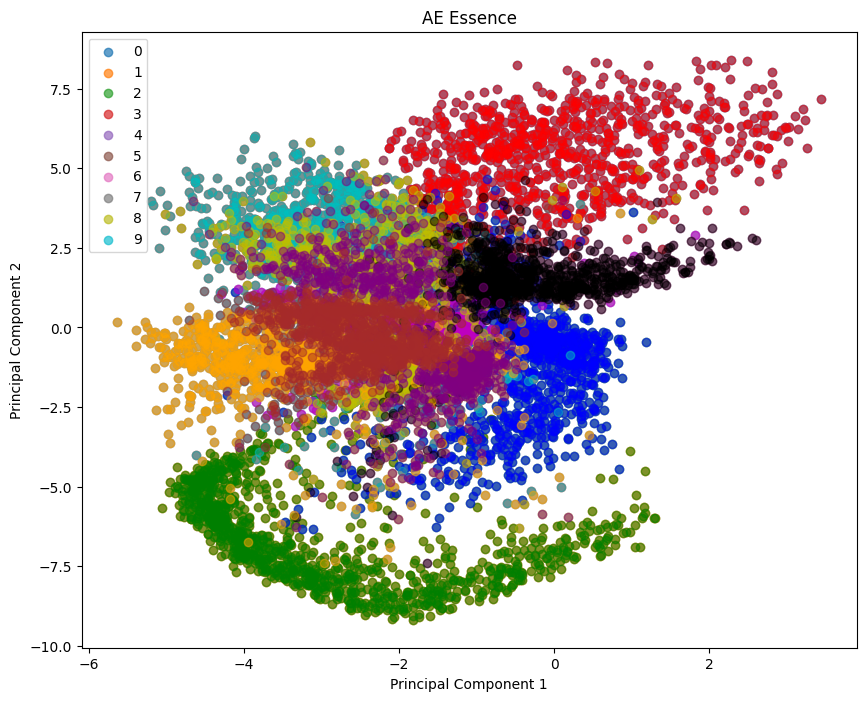

In [ ]:
x = ae.essence(torch.tensor(all_data).to(device))
plot_projected_data(x.detach().cpu(), all_labels, "AE Essence")

# EX3 Linear Autoencoder (20pts)
1. Follow the steps of EX2, but remove the nonlinear activation functions.

4. Project the data using your AE. Plot the data using ```plot_projected_data()```

In [ ]:
class Linear_AE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, ess):
      super(Linear_AE, self).__init__()
      self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.Linear(hidden_dim1, ess),
            )
      self.decoder = nn.Sequential(
            nn.Linear(ess, hidden_dim2),
            nn.Linear(hidden_dim2, input_dim),
            )

    def essence(self,x):
        return self.encoder(x)

    # def decoder(self, x):
    #   return self.decoder(x)

    def forward(self,x):
      x = x.view(-1, 784)
      x = self.encoder(x)
      x = self.decoder(x)
      x = x.view(-1,1,28,28)
      return x

In [ ]:
### Your code goes here ###

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    input_dim = 28 * 28
    hidden_dim1 = trial.suggest_int('hidden_dim1', 64, 512)
    hidden_dim2 = trial.suggest_int('hidden_dim2', 32, 256)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    model = Linear_AE(input_dim, hidden_dim1, hidden_dim2, 2).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data, _ in trainloader:
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        train_loss /= len(trainloader.dataset)

    return train_loss

    # Create a study and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objective, n_trials=10)

    # Print the best trial
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-10 08:19:18,725] A new study created in memory with name: no-name-c5f9e851-7cc6-4094-8e65-ce981fe75a0d
[I 2024-07-10 08:20:24,291] Trial 0 finished with value: 0.36178837084770205 and parameters: {'hidden_dim1': 483, 'hidden_dim2': 131, 'learning_rate': 0.0478628611328148}. Best is trial 0 with value: 0.36178837084770205.
[I 2024-07-10 08:21:29,130] Trial 1 finished with value: 0.49213385887145994 and parameters: {'hidden_dim1': 178, 'hidden_dim2': 253, 'learning_rate': 0.04752702705424243}. Best is trial 0 with value: 0.36178837084770205.
[I 2024-07-10 08:22:33,622] Trial 2 finished with value: 0.224963711309433 and parameters: {'hidden_dim1': 218, 'hidden_dim2': 169, 'learning_rate': 0.00010791564294854613}. Best is trial 2 with value: 0.224963711309433.
[I 2024-07-10 08:23:38,388] Trial 3 finished with value: 0.22363333394527435 and parameters: {'hidden_dim1': 107, 'hidden_dim2': 58, 'learning_rate': 0.011887301007448798}. Best is trial 3 with value: 0.22363333394527435.


Best trial:
  Value: 0.22363333394527435
  Params: 
    hidden_dim1: 107
    hidden_dim2: 58
    learning_rate: 0.011887301007448798


In [ ]:
# Initialize the model, loss function, and optimizer
ael = Linear_AE(28*28, 107, 58, 2)
ael = ael.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(ael.parameters(), lr=0.011887301007448798)
print(ael)

Linear_AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=107, bias=True)
    (1): Linear(in_features=107, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=58, bias=True)
    (1): Linear(in_features=58, out_features=784, bias=True)
  )
)


In [ ]:
loss = train(ael, trainloader, criterion, optimizer,  epochs=100)

  0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch [1/100], Loss: 5.0854
Epoch [6/100], Loss: 0.2562
Epoch [11/100], Loss: 0.2434
Epoch [16/100], Loss: 0.2378
Epoch [21/100], Loss: 0.2282
Epoch [26/100], Loss: 0.2261
Epoch [31/100], Loss: 0.2251
Epoch [36/100], Loss: 0.2240
Epoch [41/100], Loss: 0.2246
Epoch [46/100], Loss: 0.2237
Epoch [51/100], Loss: 0.2246
Epoch [56/100], Loss: 0.2231
Epoch [61/100], Loss: 0.2235
Epoch [66/100], Loss: 0.2238
Epoch [71/100], Loss: 0.2237
Epoch [76/100], Loss: 0.2237
Epoch [81/100], Loss: 0.2242
Epoch [86/100], Loss: 0.2239
Epoch [91/100], Loss: 0.2254
Epoch [96/100], Loss: 0.2241


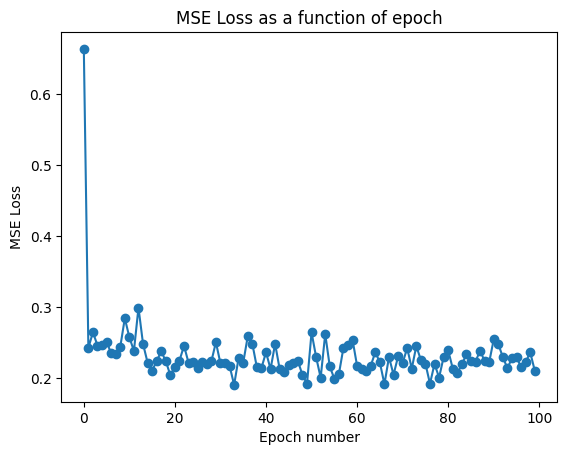

In [ ]:
plt.plot(loss, marker='o')
plt.title('MSE Loss as a function of epoch')
plt.xlabel('Epoch number')
plt.ylabel('MSE Loss')
plt.show()

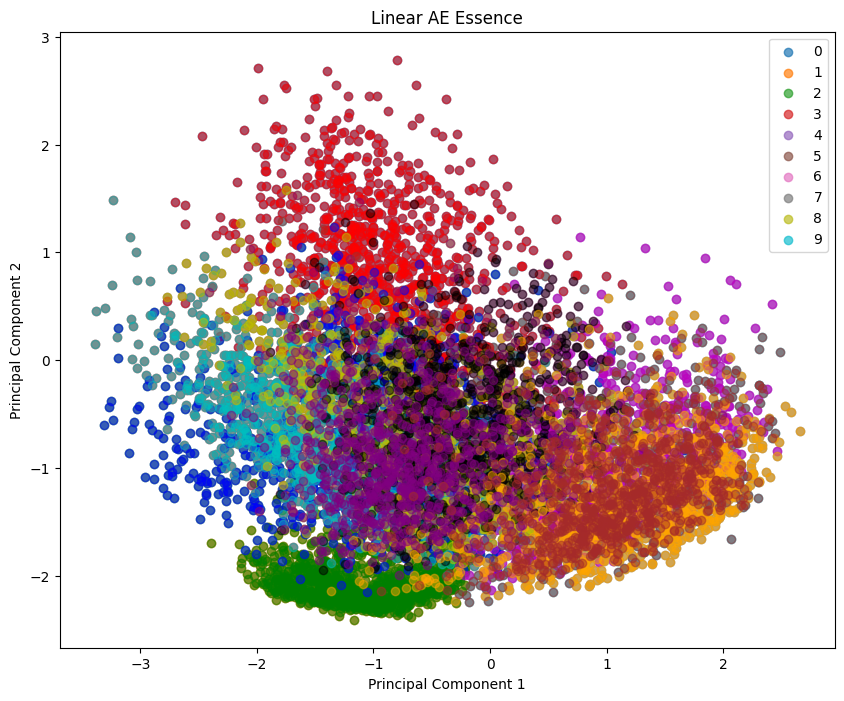

In [ ]:
x = ael.essence(torch.tensor(all_data).to(device))
plot_projected_data(x.detach().cpu(), all_labels, "Linear AE Essence")

# EX 4 - Discussion (10pts)
1. Write a new plotting function and plot the results side-by-side using subplots.
2. Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?


In [ ]:

def plot_projected_data(X, y, ax,s):
    colors = list(mcolors.TABLEAU_COLORS.values())
    scatter = None
    for label in np.unique(y):
        indices = y == label
        scatter = ax.scatter(X[indices, 0], X[indices, 1],
                             color=colors[label % len(colors)], label=str(label), alpha=0.7)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(s)

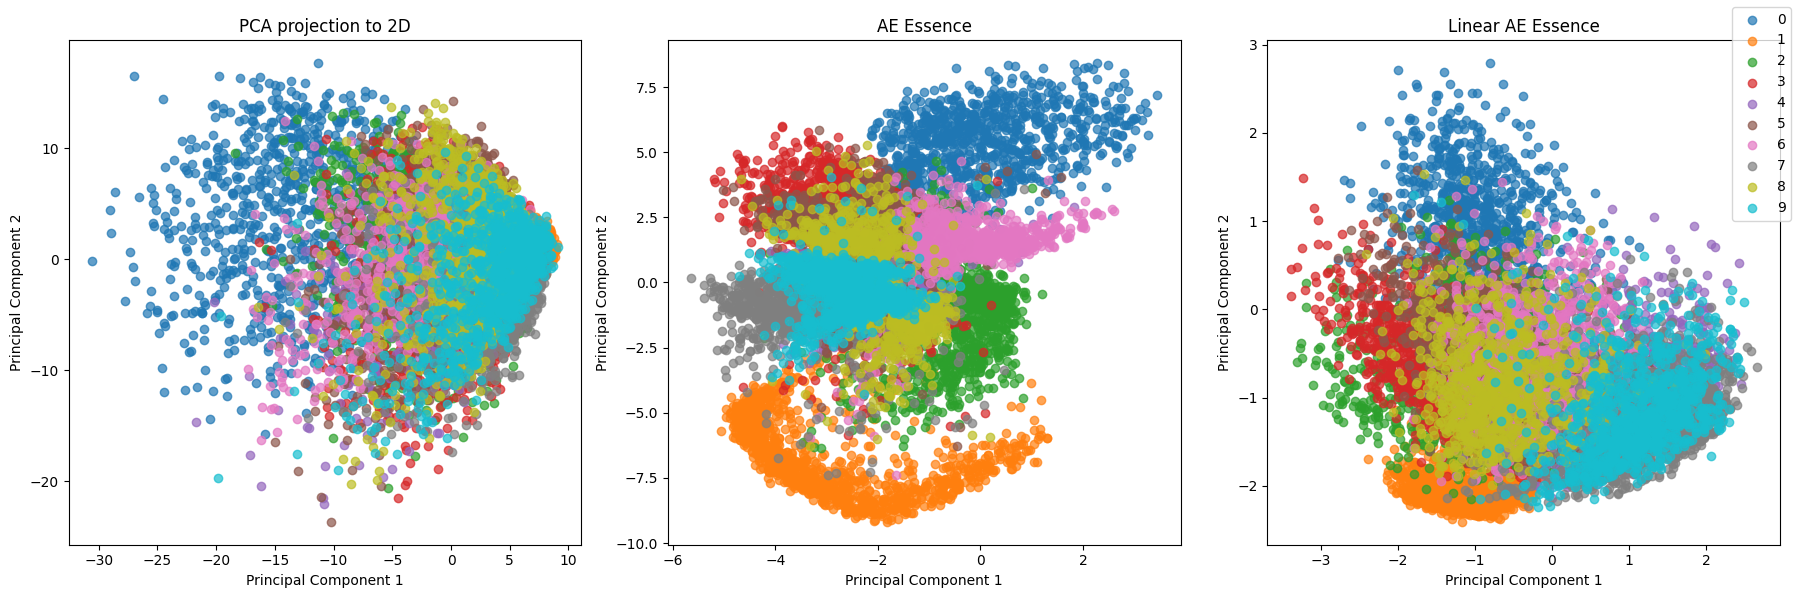

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Call plot_projected_data with different parameters
plot_projected_data(perform_PCA(all_data, 2), all_labels, axes[0], "PCA projection to 2D")
plot_projected_data(ae.essence(torch.tensor(all_data).to(device)).detach().cpu(), all_labels, axes[1], "AE Essence")
plot_projected_data(ael.essence(torch.tensor(all_data).to(device)).detach().cpu(), all_labels, axes[2], "Linear AE Essence")

# Add a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

**Optuna**

In sections 2,3 we used the Optuna package in order to optimize the chosen hyper-parameters of the network. the hyper-parameters we chose to ptimize using Optuna is the dimensions of the hidden layers and the learning rate of the optimizer.

From each optuna study, we chose the best hyper-parameters found in it, in our model in the respective section.

**Given the three figures and what we've learned about PCA and AE, answer what are the difference/similarites between the models? How is that indicated in the results?**

In PCA we reduce the dimensions of the input using the K most significant eigenvalues and their respective eigenvectors. This does not invlolve any learning and thus the classes are clustered together.

In AE, we reduce the dimensions usind the encoder, which outputs the essence of the image as it learned it. This model involves a higher learning paradigm while using non-linear activation functions that enables the model to learn more complex structures. As one can see, the best results came from this model, as it was able to differentiate between some classes.

In linear AE, we reduce the dimensions usind the encoder, which outputs the essence of the image as it learned it. Even though the model learned some of  the differences between the classes, it didn't have the non-linear activation functions, thus it was able to learn minimal diffrences. We further note that a linear AE is equivalent to a simple linaer model, with a basic matrix multplication and bias adding. This resulted in this model being better than PCA but not as good as the normal AE.

# EX 5 - Denoising AE and Classification (30pts.)
In this section you will implement and train a denosing AE to clean corrupted MNIST images.
You are given a trained MLP model (from DL PS1) with ~94% test set accuracy on the cleaned images. Again, work with only 10k images (a subset of the train set).
Your tasks are as follows:
0. Load the mlp.pth file to your project and initiate the MLP model with the trained weights.
1. Compute the test set accuracy for the clean and corrupted datasets.
2. Implemented and train autoencoder to remove the noise.
3. Visualize the results for 10 images, one for each digit (original image, corrupted image, clean image).
4. Compute the test set accuracy on the cleaned/denoised corrupted test set. Due to the randomness of the gaussian noise, run the procedure 5 times and take the average accuracy.

You may not re-train the classification network or train a new model for classification task.

### Grading for this section:
```python
10pts  # code quality and presentation
20pts = max(cleaned image accuracy + 10, 100)*0.2 #(i.e, accuracy >= 90% will give you a full grade).
```



## Load trained model

In [5]:
# MLP classifier from DL PS1 - DO NOT CHANGE
mlp_clf = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_clf.load_state_dict(torch.load('mlp.pth', map_location=torch.device(device)))


<All keys matched successfully>

## Data and functions

In [6]:
# Noise function - DO NOT CHANGE
def add_gaussian_noise(images, mean=0.0, std=2):
    images = images.to(device)
    noise = torch.randn(images.size()).to(device) * std + mean
    noisy_images = images + noise
    return noisy_images


# Accuracy - DO NOT CHANGE
def compute_accuracy(model, testloader, denoise_model=None, add_noise=False):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            # False for clean images, True for corrupted/noisy
            if add_noise:
              images = add_gaussian_noise(images)
            # Denoise the image before the classifier
            if denoise_model is not None:
              images = denoise_model(images)
            # reshape to vector form for the MLP
            images = images.view(images.shape[0], -1)
            images, labels = images.to(device), labels.to(device)
            model = model.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy


In [7]:
# Compute and print test accuracy for clean and corrupted images
print(f"The clean Test data accuracy of the classifier is: {compute_accuracy(mlp_clf, testloader)}")
print(f"The corrupted Test data accuracy of the classifier is: {compute_accuracy(mlp_clf, testloader, add_noise=True)}")

The clean Test data accuracy of the classifier is: 93.98
The corrupted Test data accuracy of the classifier is: 58.84


In [ ]:
### Your code goes here ###

### Two Approaches
In this section, we have decided to try 2 different approches to denoise the corrupted MNIST data, one is a fully connected AE, and the other is a convolutional AE, loosly based on the structure of the famous AlexNet.

In [8]:
def trainD(model, train_loader, criterion, optimizer, epochs=25):
    model.train()
    los = []
    with tqdm(total=epochs, unit="epoch", position=0, leave=True) as pbar:
      for epoch in range(epochs):
        running_loss = 0.0
        for images, _ in train_loader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images)
            optimizer.zero_grad()
            outputs = model(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        los.append(loss.item())
        pbar.set_postfix(loss=running_loss/len(train_loader))
        pbar.update(1)
        if epoch % 20 == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    return los

In [9]:
def avg_p(model, loader):
  acc = []
  for i in range(5):
    acc.append(compute_accuracy(mlp_clf, loader, model, True))
  return round(np.array(acc).mean(),4)

In [10]:
def denoise(model, noisy_images):
    model.eval()
    with torch.no_grad():
        cleaned_images = model(noisy_images).to(device)
    return cleaned_images

def plot_results(model, loader):
    digit_examples = {}
    for images, labels in loader:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in digit_examples:
                digit_examples[label] = images[i]
            if len(digit_examples) == 10:
                break
        if len(digit_examples) == 10:
            break

    images = torch.stack([digit_examples[digit] for digit in range(10)])
    noisy_images = add_gaussian_noise(images)
    cleaned_images = denoise(model, noisy_images)

    fig, axes = plt.subplots(10, 3, figsize=(10, 20))
    for i in range(10):
        axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title(f'Original Image {i}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title('Noisy Image')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(cleaned_images[i].cpu().squeeze(), cmap='gray')
        axes[i, 2].set_title('Cleaned Image')
        axes[i, 2].axis('off')
    plt.show()

### Fully Connected AE

This model, represented by class AEF, is a model where both the encoder and the decoder are fully connected networks, each have 4 hidden layers and use ReLU as their activation functions.

We decided to use the Optuna optimizer tool in order to find the best hyper-parameters for this model, specifficaly the dimesions of each hidden layer in the encoder and the decoder, and the learning rate.

**Note** - We choose 4 hidden layers in each parts of the network and the ranges of the dimensions of each hidden layers after a lot of expirements to decide the best.

In [ ]:
class AEF(nn.Module):
    def __init__(self, inp, h1, h2, h3, h4, h5, h6, h7):
        super(AEF, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(inp, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, h3),
            nn.ReLU(),
            nn.Linear(h3, h4),

        )
        self.decoder = nn.Sequential(
            nn.Linear(h4, h5),
            nn.ReLU(),
            nn.Linear(h5, h6),
            nn.ReLU(),
            nn.Linear(h6, h7),
            nn.ReLU(),
            nn.Linear(h7, inp),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, 1, 28, 28)


        return x

In [ ]:
def objectiveD(trial):
    input_dim = 28 * 28
    h1 = trial.suggest_int('h1', 512, 784)
    h2 = trial.suggest_int('h2', 256, 512)
    h3 = trial.suggest_int('h3', 128, 256)
    h4 = trial.suggest_int('h4', 64, 128)
    h5 = trial.suggest_int('h5', 128, 256)
    h6 = trial.suggest_int('h6', 256, 512)
    h7 = trial.suggest_int('h7', 512, 784)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)

    aed = AEF(input_dim, h1, h2, h3, h4, h5, h6, h7).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(aed.parameters(), lr=learning_rate)

    num_epochs = 50
    for epoch in range(num_epochs):
        aed.train()
        train_loss = 0
        for images, _ in trainloader:
            images = images.to(device)
            noisy_images = add_gaussian_noise(images)
            optimizer.zero_grad()
            outputs = aed(noisy_images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(trainloader.dataset)
    return train_loss

    # Create a study and optimize the objective function
study = optuna.create_study(direction='minimize', sampler=TPESampler(), pruner=MedianPruner())
study.optimize(objectiveD, n_trials=80)

    # Print the best trial
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-10 08:36:59,928] A new study created in memory with name: no-name-560e6d27-2061-42ce-b867-4e11131e2d6a
[I 2024-07-10 08:39:02,948] Trial 0 finished with value: 0.1204723918557167 and parameters: {'h1': 656, 'h2': 309, 'h3': 157, 'h4': 64, 'h5': 133, 'h6': 305, 'h7': 572, 'learning_rate': 0.0008718922095129597}. Best is trial 0 with value: 0.1204723918557167.
[I 2024-07-10 08:41:03,366] Trial 1 finished with value: 0.15756756093502045 and parameters: {'h1': 538, 'h2': 445, 'h3': 131, 'h4': 81, 'h5': 237, 'h6': 361, 'h7': 628, 'learning_rate': 0.003014220589901233}. Best is trial 0 with value: 0.1204723918557167.
[I 2024-07-10 08:43:04,687] Trial 2 finished with value: 0.2219508462190628 and parameters: {'h1': 573, 'h2': 410, 'h3': 193, 'h4': 80, 'h5': 189, 'h6': 456, 'h7': 749, 'learning_rate': 1.7379767149182552e-05}. Best is trial 0 with value: 0.1204723918557167.
[I 2024-07-10 08:45:06,307] Trial 3 finished with value: 0.17906501069068909 and parameters: {'h1': 761, 'h2': 

In [ ]:
aef = AEF(28*28 ,563, 310, 191, 112, 173, 412, 570).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(aef.parameters(), lr= 0.0011014901224398388)
print(aef)

AEF(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=563, bias=True)
    (1): ReLU()
    (2): Linear(in_features=563, out_features=310, bias=True)
    (3): ReLU()
    (4): Linear(in_features=310, out_features=191, bias=True)
    (5): ReLU()
    (6): Linear(in_features=191, out_features=112, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=112, out_features=173, bias=True)
    (1): ReLU()
    (2): Linear(in_features=173, out_features=412, bias=True)
    (3): ReLU()
    (4): Linear(in_features=412, out_features=570, bias=True)
    (5): ReLU()
    (6): Linear(in_features=570, out_features=784, bias=True)
  )
)


In [ ]:
loss = trainD(aef, trainloader, criterion, optimizer, 500)

  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch [1/500], Loss: 0.3383
Epoch [21/500], Loss: 0.1375
Epoch [41/500], Loss: 0.1213
Epoch [61/500], Loss: 0.1138
Epoch [81/500], Loss: 0.1086
Epoch [101/500], Loss: 0.1060
Epoch [121/500], Loss: 0.1034
Epoch [141/500], Loss: 0.1031
Epoch [161/500], Loss: 0.1004
Epoch [181/500], Loss: 0.0994
Epoch [201/500], Loss: 0.0988
Epoch [221/500], Loss: 0.0978
Epoch [241/500], Loss: 0.0981
Epoch [261/500], Loss: 0.0970
Epoch [281/500], Loss: 0.0962
Epoch [301/500], Loss: 0.0966
Epoch [321/500], Loss: 0.0950
Epoch [341/500], Loss: 0.0951
Epoch [361/500], Loss: 0.0943
Epoch [381/500], Loss: 0.0946
Epoch [401/500], Loss: 0.0945
Epoch [421/500], Loss: 0.0942
Epoch [441/500], Loss: 0.0936
Epoch [461/500], Loss: 0.0935
Epoch [481/500], Loss: 0.0934


### Convolutional AE
This model was loosly based on AlexNet, as the econder and the decoder have 5 convolution layers in different dimesions.

Here we have decided to nor use optuna, due to the complexity of the model.

In [11]:
class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1),  # (batch, 96, 14, 14)
            nn.ReLU(),
            nn.Conv2d(96, 256, kernel_size=3, stride=2, padding=1),  # (batch, 256, 7, 7)
            nn.ReLU(),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # (batch, 384, 7, 7)
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),  # (batch, 384, 7, 7)
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),  # (batch, 256, 7, 7)
            # nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 384, kernel_size=3, stride=1, padding=1),  # (batch, 384, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(384, 384, kernel_size=3, stride=1, padding=1),  # (batch, 384, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(384, 256, kernel_size=3, stride=1, padding=1),  # (batch, 256, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(256, 96, kernel_size=3, stride=2, padding=1, output_padding=1),  # (batch, 96, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(96, 1, kernel_size=4, stride=2, padding=1),  # (batch, 1, 28, 28)
            # nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [12]:
aec = AEC().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(aec.parameters(), lr= 0.001)
print(aec)

AEC(
  (encoder): Sequential(
    (0): Conv2d(1, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(96, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(256, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): ReLU()
    (8): ConvTranspose2d(96, 1, kernel_size=(4, 4), stride=(2, 2),

In [13]:
loss = trainD(aec, trainloader, criterion, optimizer, 500)

  0%|          | 0/500 [00:00<?, ?epoch/s]

Epoch [1/500], Loss: 0.4664
Epoch [21/500], Loss: 0.1011
Epoch [41/500], Loss: 0.0931
Epoch [61/500], Loss: 0.0898
Epoch [81/500], Loss: 0.0867
Epoch [101/500], Loss: 0.0861
Epoch [121/500], Loss: 0.0835
Epoch [141/500], Loss: 0.0835
Epoch [161/500], Loss: 0.0824
Epoch [181/500], Loss: 0.0812
Epoch [201/500], Loss: 0.0812
Epoch [221/500], Loss: 0.0802
Epoch [241/500], Loss: 0.0787
Epoch [261/500], Loss: 0.0793
Epoch [281/500], Loss: 0.0781
Epoch [301/500], Loss: 0.0779
Epoch [321/500], Loss: 0.0772
Epoch [341/500], Loss: 0.0783
Epoch [361/500], Loss: 0.0766
Epoch [381/500], Loss: 0.0769
Epoch [401/500], Loss: 0.0755
Epoch [421/500], Loss: 0.0762
Epoch [441/500], Loss: 0.0754
Epoch [461/500], Loss: 0.0752
Epoch [481/500], Loss: 0.0748


### Best model
As one can see, the best model was the convolusional AE by a landslide, on the task of reconstructing MNIST.

In [14]:
aed = aec

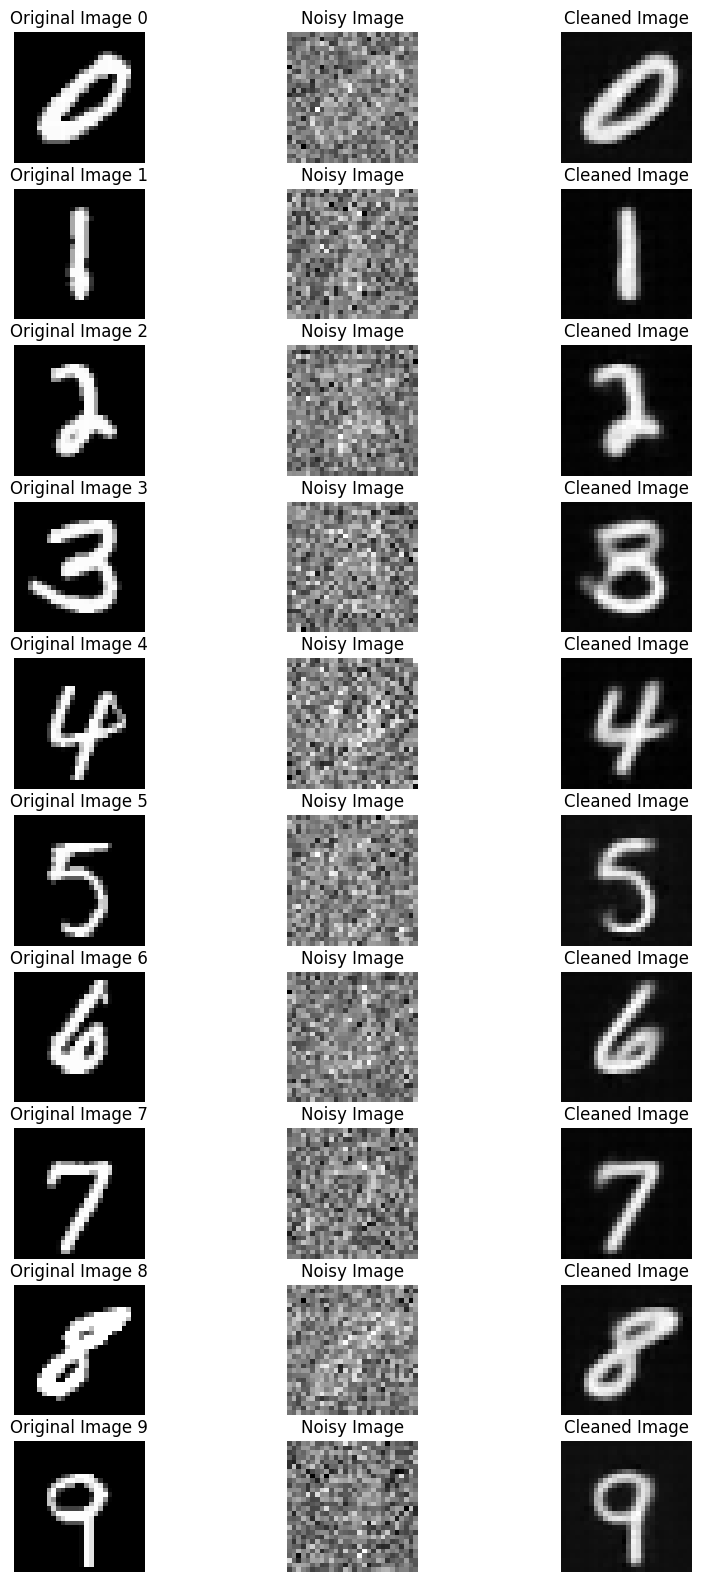

In [18]:
plot_results(aed, trainloader)

In [31]:
print(f"The avarage reconstructed Test data accuracy of the classifier is: {avg_p(aed,testloader)}")

The avarage reconstructed Test data accuracy of the classifier is: 87.554
